# 06. More events (200)

Use the same datasets and models, but with 200 events per session.

In [1]:
import pandas as pd
import numpy as np

import gc
from typing import Tuple
import logging

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras import optimizers
from keras import callbacks


from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

import matplotlib.pyplot as plt
import seaborn as sns
import yellowbrick as yb

2023-02-26 17:03:12.562174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 17:03:13.469733: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-26 17:03:13.469828: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-26 17:03:13.469836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [3]:
# Set the GPU memory from growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-02-26 17:03:15.101462: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 17:03:15.167026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 17:03:15.167174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Load the prepared and vectorized data

In [4]:
X_train = np.load('data/05/2000_200/X_train.npz')['arr_0']
X_val = np.load('data/05/2000_200/X_val.npz')['arr_0']
X_test = np.load('data/05/2000_200/X_test.npz')['arr_0']

y_train = np.load('data/05/2000_200/y_train.npz')['arr_0']
y_val = np.load('data/05/2000_200/y_val.npz')['arr_0']
y_test = np.load('data/05/2000_200/y_test.npz')['arr_0']

gc.collect()

66

In [5]:
print('X_train.shape:', X_train.shape)
print('X_val.shape:', X_val.shape)
print('X_test.shape:', X_test.shape)

print('y_train.shape:', y_train.shape)
print('y_val.shape:', y_val.shape)
print('y_test.shape:', y_test.shape)

X_train.shape: (25200, 200, 340)
X_val.shape: (5400, 200, 340)
X_test.shape: (5400, 200, 340)
y_train.shape: (25200,)
y_val.shape: (5400,)
y_test.shape: (5400,)


## Modeling Functions

In [6]:
def plot_loss(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the loss and validation loss.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['loss'])
    
    if ('val_loss' in history.history):
        plt.plot(epochs, history.history['val_loss'])
        plt.legend(['Training loss', 'Validation loss'], loc='upper left')
        plt.title('Training and validation loss')
    else:
        plt.title('Training loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()        

In [7]:
def plot_accuracy(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the accuracy and validation accuracy.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['accuracy'])

    if ('val_accuracy' in history.history):
        plt.plot(epochs, history.history['val_accuracy'])
        plt.legend(['Training acc', 'Validation acc'], loc='upper left')
        plt.title('Training and validation accuracy')
    else:
        plt.title('Training accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

In [8]:
def optimize_f1(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[float, float, float]:
    """
    Optimize the F1 score.

    Parameters
    ----------
    y_true : np.ndarray
        The true labels.
    y_score : np.ndarray
        The predicted labels.

    Returns
    -------
    Tuple[float, float, float]
        The optimized threshold, precision, and recall.
    """
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0

    for threshold in np.arange(0, 1, 0.01):
        y_pred = (y_score > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)
        #print(f'Threshold: {threshold:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_precision, best_recall

In [9]:
def train_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list) -> callbacks.History:
    """
    Train the keras model based on the parameters.

    Parameters
    ----------
    model : keras.models
        The model to train.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    
    Returns
    -------
    keras.callbacks.History
        The history of the training.
    """
    # compile the model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)
    
    # fit the model
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val))
    
    return history

In [10]:
def test_model(
        model,
        history: callbacks.History,
        X_test: np.ndarray,
        y_test: np.ndarray) -> float:
    """
    Test the model based on the test data.

    Parameters
    ----------
    model : keras.models
        The model to test.
    history : keras.callbacks.History
        The history of the training.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    
    plot_loss(history)
    plot_accuracy(history)

    y_test_score = model.predict(X_test)
    threshold, _, _ = optimize_f1(y_test, y_test_score)

    print(classification_report(y_test, y_test_score > threshold))
    print(f'Optimized threshold for best F1: {threshold:.2f}')

    gc.collect()

    return threshold

In [11]:
def train_and_test_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list) -> float:
    """
    Train and test the model.

    Parameters
    ----------
    model : keras.models
        The model to train and test.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    history = train_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)
    
    gc.collect()

    return test_model(model, history, X_test, y_test)

In [12]:
def global_train_model(model,
                       epochs: int,
                       batch_size: int,
                       optimizer,
                       loss: str,
                       metrics: list) -> float:
        """
        Train the model using the global data.

        Parameters
        ----------
        model : keras.models
                The model to train.
        epochs : int
                The number of epochs.
        batch_size : int
                The batch size.
        optimizer : keras.optimizers
                The optimizer.
        loss : str
                The loss function.
        metrics : list
                The metrics.

        Returns
        -------
        float
                The optimized threshold for the best F1 score.
        """
        global X_train
        global y_train
        global X_val
        global y_val
        global X_test
        global y_test

        return train_and_test_model(
                model=model,
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
                X_test=X_test,
                y_test=y_test,
                epochs=epochs,
                batch_size=batch_size,
                optimizer=optimizer,
                loss=loss,
                metrics=metrics)

## Parameters

In [13]:
learning_rate = 0.001
first_layer_size = 32
epochs = 10
batch_size = 10

loss = 'binary_crossentropy'
metrics = ['accuracy']

## Simple Flattening

A very simple model that is not considering the sequence of events and flattens the input data.

In [14]:
# define the model
model = Sequential()
model.add(layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dense(first_layer_size, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2023-02-26 16:11:57.809470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 16:11:57.809940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 16:11:57.810080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 16:11:57.810185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

2023-02-26 16:12:02.405317: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 6854400000 exceeds 10% of free system memory.
2023-02-26 16:12:58.129796: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 6854400000 exceeds 10% of free system memory.


Epoch 1/10
  89/2520 [>.............................] - ETA: 4s - loss: 0.6650 - accuracy: 0.6888 

2023-02-26 16:13:03.293327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2490/2520 [============================>.] - ETA: 0s - loss: 0.5781 - accuracy: 0.7069

2023-02-26 16:13:11.262183: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1468800000 exceeds 10% of free system memory.
2023-02-26 16:13:11.834738: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1468800000 exceeds 10% of free system memory.


2520/2520 [==============================] - 12s 4ms/step - loss: 0.5777 - accuracy: 0.7072 - val_loss: 0.5607 - val_accuracy: 0.7381
Epoch 2/10
2520/2520 [==============================] - 5s 2ms/step - loss: 0.5367 - accuracy: 0.7392 - val_loss: 0.5321 - val_accuracy: 0.7374
Epoch 3/10
2520/2520 [==============================] - 5s 2ms/step - loss: 0.5239 - accuracy: 0.7449 - val_loss: 0.5225 - val_accuracy: 0.7443
Epoch 4/10
2520/2520 [==============================] - 5s 2ms/step - loss: 0.5225 - accuracy: 0.7461 - val_loss: 0.5262 - val_accuracy: 0.7417
Epoch 5/10
2520/2520 [==============================] - 5s 2ms/step - loss: 0.5192 - accuracy: 0.7478 - val_loss: 0.5520 - val_accuracy: 0.7444
Epoch 6/10
2520/2520 [==============================] - 5s 2ms/step - loss: 0.5191 - accuracy: 0.7471 - val_loss: 0.5416 - val_accuracy: 0.7428
Epoch 7/10
2520/2520 [==============================] - 5s 2ms/step - loss: 0.5205 - accuracy: 0.7487 - val_loss: 0.5211 - val_accuracy: 0.7428
Ep

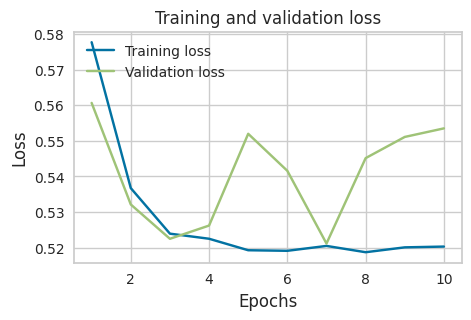

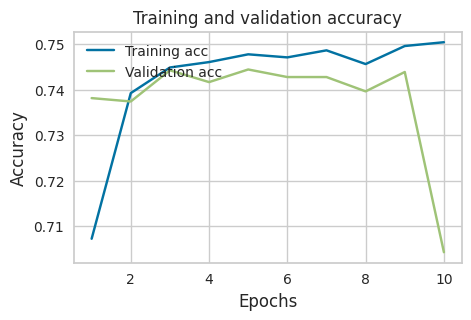

2023-02-26 16:14:04.790471: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1468800000 exceeds 10% of free system memory.


169/169 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.51      0.52      0.51      1554
           1       0.80      0.80      0.80      3846

    accuracy                           0.72      5400
   macro avg       0.66      0.66      0.66      5400
weighted avg       0.72      0.72      0.72      5400

Optimized threshold for best F1: 0.48


0.48

In [15]:
global_train_model(
    model=model,
    epochs=epochs,
    batch_size=batch_size,
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics)

## Simple RNN

In [16]:
model = Sequential()
model.add(layers.SimpleRNN(first_layer_size, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dense(1, activation='sigmoid'))

Epoch 1/10
2520/2520 [==============================] - 72s 28ms/step - loss: 0.5399 - accuracy: 0.7280 - val_loss: 0.5282 - val_accuracy: 0.7411
Epoch 2/10
2520/2520 [==============================] - 68s 27ms/step - loss: 0.5202 - accuracy: 0.7413 - val_loss: 0.5264 - val_accuracy: 0.7400
Epoch 3/10
2520/2520 [==============================] - 69s 27ms/step - loss: 0.5162 - accuracy: 0.7445 - val_loss: 0.5242 - val_accuracy: 0.7426
Epoch 4/10
2520/2520 [==============================] - 68s 27ms/step - loss: 0.5121 - accuracy: 0.7475 - val_loss: 0.5238 - val_accuracy: 0.7470
Epoch 5/10
2520/2520 [==============================] - 68s 27ms/step - loss: 0.5089 - accuracy: 0.7496 - val_loss: 0.5267 - val_accuracy: 0.7393
Epoch 6/10
2520/2520 [==============================] - 68s 27ms/step - loss: 0.5064 - accuracy: 0.7505 - val_loss: 0.5310 - val_accuracy: 0.7417
Epoch 7/10
2520/2520 [==============================] - 68s 27ms/step - loss: 0.5026 - accuracy: 0.7540 - val_loss: 0.5305 -

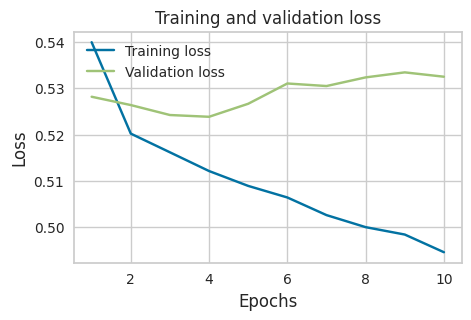

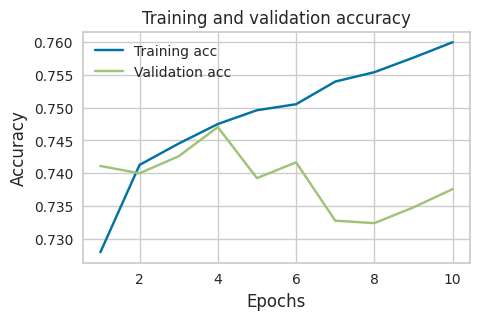

169/169 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

           0       0.48      0.55      0.51      1554
           1       0.81      0.77      0.79      3846

    accuracy                           0.70      5400
   macro avg       0.65      0.66      0.65      5400
weighted avg       0.71      0.70      0.71      5400

Optimized threshold for best F1: 0.64


0.64

In [17]:
global_train_model(
    model=model,
    epochs=epochs,
    batch_size=batch_size,
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics)

## Simple GRU

In [18]:
model = Sequential()
model.add(layers.GRU(first_layer_size, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dense(1, activation='sigmoid'))

Epoch 1/10


2023-02-26 16:27:18.281324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800


2520/2520 [==============================] - 28s 8ms/step - loss: 0.5352 - accuracy: 0.7322 - val_loss: 0.5239 - val_accuracy: 0.7417
Epoch 2/10
2520/2520 [==============================] - 14s 6ms/step - loss: 0.5213 - accuracy: 0.7413 - val_loss: 0.5199 - val_accuracy: 0.7417
Epoch 3/10
2520/2520 [==============================] - 14s 5ms/step - loss: 0.5176 - accuracy: 0.7425 - val_loss: 0.5222 - val_accuracy: 0.7430
Epoch 4/10
2520/2520 [==============================] - 14s 5ms/step - loss: 0.5151 - accuracy: 0.7441 - val_loss: 0.5180 - val_accuracy: 0.7452
Epoch 5/10
2520/2520 [==============================] - 14s 6ms/step - loss: 0.5123 - accuracy: 0.7460 - val_loss: 0.5182 - val_accuracy: 0.7437
Epoch 6/10
2520/2520 [==============================] - 14s 6ms/step - loss: 0.5097 - accuracy: 0.7485 - val_loss: 0.5189 - val_accuracy: 0.7415
Epoch 7/10
2520/2520 [==============================] - 14s 5ms/step - loss: 0.5063 - accuracy: 0.7500 - val_loss: 0.5194 - val_accuracy: 0.7

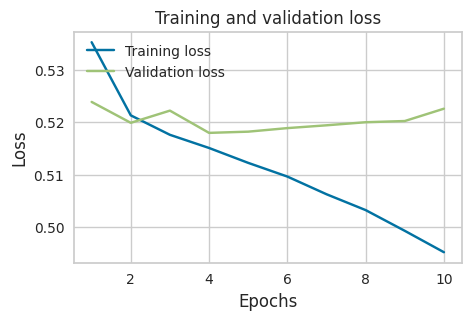

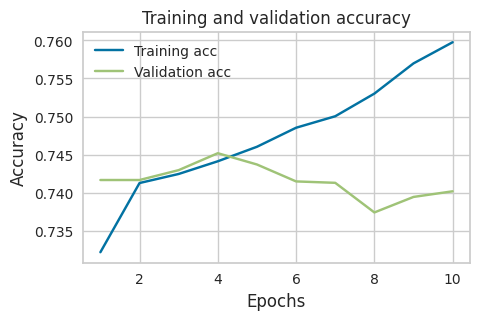

169/169 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.53      0.50      0.52      1554
           1       0.80      0.82      0.81      3846

    accuracy                           0.73      5400
   macro avg       0.67      0.66      0.66      5400
weighted avg       0.72      0.73      0.73      5400

Optimized threshold for best F1: 0.61


0.61

In [19]:
global_train_model(
    model=model,
    epochs=epochs,
    batch_size=batch_size,
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics)

## Simple LSTM

In [20]:
model = Sequential()
model.add(layers.LSTM(first_layer_size, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dense(1, activation='sigmoid'))

Epoch 1/10
2520/2520 [==============================] - 21s 8ms/step - loss: 0.5334 - accuracy: 0.7343 - val_loss: 0.5270 - val_accuracy: 0.7341
Epoch 2/10
2520/2520 [==============================] - 14s 6ms/step - loss: 0.5215 - accuracy: 0.7410 - val_loss: 0.5226 - val_accuracy: 0.7437
Epoch 3/10
2520/2520 [==============================] - 14s 6ms/step - loss: 0.5178 - accuracy: 0.7426 - val_loss: 0.5208 - val_accuracy: 0.7415
Epoch 4/10
2520/2520 [==============================] - 14s 5ms/step - loss: 0.5163 - accuracy: 0.7436 - val_loss: 0.5210 - val_accuracy: 0.7413
Epoch 5/10
2520/2520 [==============================] - 14s 6ms/step - loss: 0.5150 - accuracy: 0.7439 - val_loss: 0.5198 - val_accuracy: 0.7443
Epoch 6/10
2520/2520 [==============================] - 14s 6ms/step - loss: 0.5132 - accuracy: 0.7462 - val_loss: 0.5198 - val_accuracy: 0.7407
Epoch 7/10
2520/2520 [==============================] - 14s 5ms/step - loss: 0.5114 - accuracy: 0.7462 - val_loss: 0.5200 - val_ac

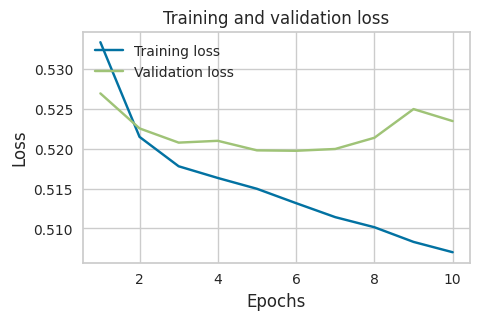

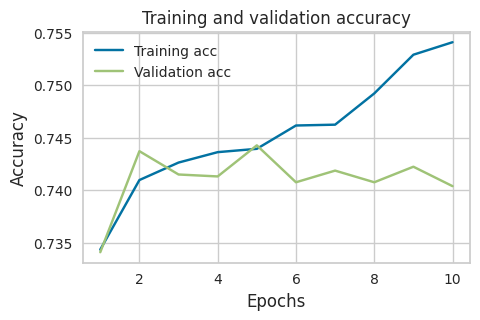

169/169 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      1554
           1       0.80      0.81      0.81      3846

    accuracy                           0.72      5400
   macro avg       0.66      0.66      0.66      5400
weighted avg       0.72      0.72      0.72      5400

Optimized threshold for best F1: 0.59


0.59

In [21]:
global_train_model(
    model=model,
    epochs=epochs,
    batch_size=batch_size,
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics)

### Limit epocs to 8

Epoch 1/8
2520/2520 [==============================] - 21s 8ms/step - loss: 0.5055 - accuracy: 0.7546 - val_loss: 0.5256 - val_accuracy: 0.7426
Epoch 2/8
2520/2520 [==============================] - 14s 6ms/step - loss: 0.5030 - accuracy: 0.7550 - val_loss: 0.5263 - val_accuracy: 0.7420
Epoch 3/8
2520/2520 [==============================] - 14s 6ms/step - loss: 0.5015 - accuracy: 0.7569 - val_loss: 0.5238 - val_accuracy: 0.7430
Epoch 4/8
2520/2520 [==============================] - 14s 6ms/step - loss: 0.5000 - accuracy: 0.7588 - val_loss: 0.5252 - val_accuracy: 0.7385
Epoch 5/8
2520/2520 [==============================] - 14s 6ms/step - loss: 0.4973 - accuracy: 0.7599 - val_loss: 0.5277 - val_accuracy: 0.7350
Epoch 6/8
2520/2520 [==============================] - 14s 5ms/step - loss: 0.4950 - accuracy: 0.7622 - val_loss: 0.5274 - val_accuracy: 0.7393
Epoch 7/8
2520/2520 [==============================] - 14s 6ms/step - loss: 0.4930 - accuracy: 0.7651 - val_loss: 0.5294 - val_accuracy:

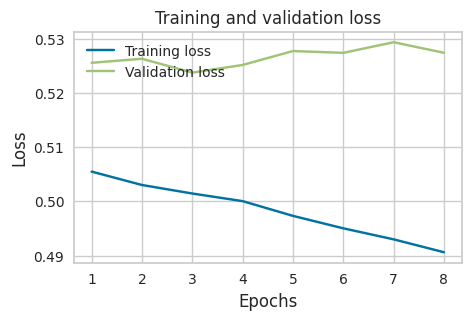

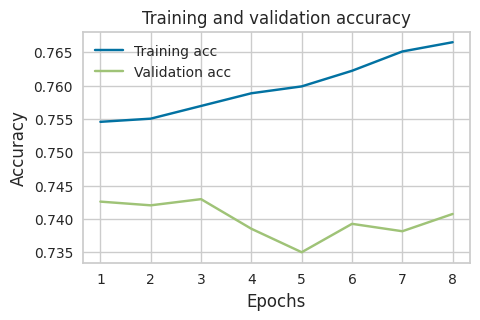

169/169 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.52      0.47      0.49      1554
           1       0.79      0.82      0.81      3846

    accuracy                           0.72      5400
   macro avg       0.66      0.65      0.65      5400
weighted avg       0.71      0.72      0.72      5400

Optimized threshold for best F1: 0.60


0.6

In [22]:
global_train_model(
    model=model,
    epochs=8,
    batch_size=batch_size,
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics)

### Increase batch size

Epoch 1/8
394/394 [==============================] - 12s 26ms/step - loss: 0.4814 - accuracy: 0.7713 - val_loss: 0.5319 - val_accuracy: 0.7328
Epoch 2/8
394/394 [==============================] - 4s 10ms/step - loss: 0.4744 - accuracy: 0.7766 - val_loss: 0.5340 - val_accuracy: 0.7276
Epoch 3/8
394/394 [==============================] - 4s 10ms/step - loss: 0.4694 - accuracy: 0.7816 - val_loss: 0.5424 - val_accuracy: 0.7306
Epoch 4/8
394/394 [==============================] - 4s 10ms/step - loss: 0.4657 - accuracy: 0.7847 - val_loss: 0.5413 - val_accuracy: 0.7311
Epoch 5/8
394/394 [==============================] - 4s 10ms/step - loss: 0.4618 - accuracy: 0.7873 - val_loss: 0.5440 - val_accuracy: 0.7302
Epoch 6/8
394/394 [==============================] - 4s 10ms/step - loss: 0.4585 - accuracy: 0.7916 - val_loss: 0.5500 - val_accuracy: 0.7276
Epoch 7/8
394/394 [==============================] - 4s 10ms/step - loss: 0.4551 - accuracy: 0.7912 - val_loss: 0.5496 - val_accuracy: 0.7309
Epoch

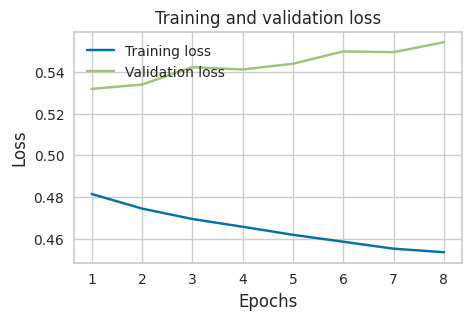

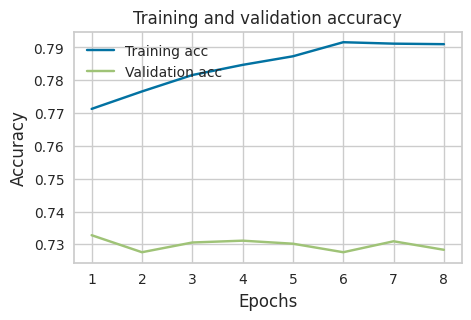

169/169 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.50      0.44      0.47      1554
           1       0.78      0.83      0.80      3846

    accuracy                           0.71      5400
   macro avg       0.64      0.63      0.64      5400
weighted avg       0.70      0.71      0.71      5400

Optimized threshold for best F1: 0.56


0.56

In [23]:
global_train_model(
    model=model,
    epochs=8,
    batch_size=64,
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics)

### Decrease learning rate

Epoch 1/8
394/394 [==============================] - 15s 34ms/step - loss: 0.4413 - accuracy: 0.8022 - val_loss: 0.5543 - val_accuracy: 0.7287
Epoch 2/8
394/394 [==============================] - 4s 10ms/step - loss: 0.4364 - accuracy: 0.8053 - val_loss: 0.5557 - val_accuracy: 0.7298
Epoch 3/8
394/394 [==============================] - 4s 10ms/step - loss: 0.4338 - accuracy: 0.8076 - val_loss: 0.5573 - val_accuracy: 0.7281
Epoch 4/8
394/394 [==============================] - 4s 10ms/step - loss: 0.4315 - accuracy: 0.8089 - val_loss: 0.5582 - val_accuracy: 0.7285
Epoch 5/8
394/394 [==============================] - 4s 9ms/step - loss: 0.4298 - accuracy: 0.8108 - val_loss: 0.5595 - val_accuracy: 0.7269
Epoch 6/8
394/394 [==============================] - 4s 10ms/step - loss: 0.4281 - accuracy: 0.8114 - val_loss: 0.5604 - val_accuracy: 0.7254
Epoch 7/8
394/394 [==============================] - 4s 10ms/step - loss: 0.4267 - accuracy: 0.8115 - val_loss: 0.5621 - val_accuracy: 0.7261
Epoch 

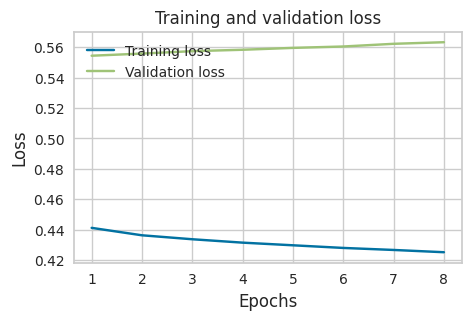

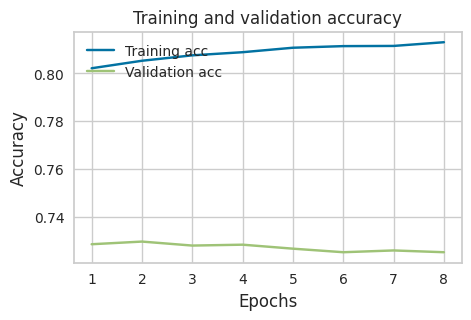

169/169 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.48      0.50      0.49      1554
           1       0.80      0.78      0.79      3846

    accuracy                           0.70      5400
   macro avg       0.64      0.64      0.64      5400
weighted avg       0.71      0.70      0.70      5400

Optimized threshold for best F1: 0.62


0.62

In [24]:
global_train_model(
    model=model,
    epochs=8,
    batch_size=64,
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss=loss,
    metrics=metrics)

### Add a dropout layer

In [25]:
model = Sequential()
model.add(layers.LSTM(first_layer_size, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

Epoch 1/20
394/394 [==============================] - 13s 27ms/step - loss: 0.6345 - accuracy: 0.6571 - val_loss: 0.5824 - val_accuracy: 0.7120
Epoch 2/20
394/394 [==============================] - 4s 10ms/step - loss: 0.5629 - accuracy: 0.7208 - val_loss: 0.5262 - val_accuracy: 0.7383
Epoch 3/20
394/394 [==============================] - 4s 10ms/step - loss: 0.5360 - accuracy: 0.7321 - val_loss: 0.5188 - val_accuracy: 0.7420
Epoch 4/20
394/394 [==============================] - 4s 10ms/step - loss: 0.5304 - accuracy: 0.7348 - val_loss: 0.5167 - val_accuracy: 0.7409
Epoch 5/20
394/394 [==============================] - 4s 10ms/step - loss: 0.5277 - accuracy: 0.7392 - val_loss: 0.5164 - val_accuracy: 0.7419
Epoch 6/20
394/394 [==============================] - 4s 10ms/step - loss: 0.5255 - accuracy: 0.7373 - val_loss: 0.5161 - val_accuracy: 0.7431
Epoch 7/20
394/394 [==============================] - 4s 10ms/step - loss: 0.5249 - accuracy: 0.7381 - val_loss: 0.5161 - val_accuracy: 0.745

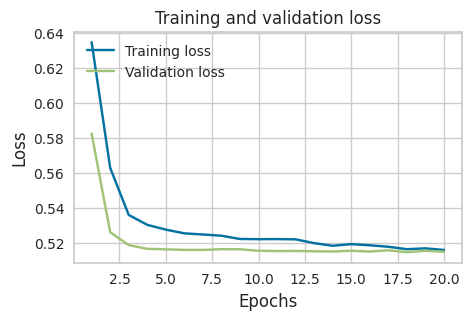

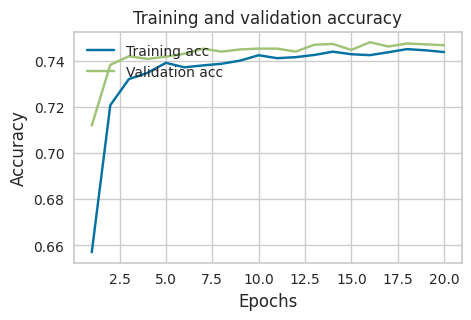

169/169 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      1554
           1       0.80      0.81      0.81      3846

    accuracy                           0.72      5400
   macro avg       0.66      0.66      0.66      5400
weighted avg       0.72      0.72      0.72      5400

Optimized threshold for best F1: 0.62


0.62

In [26]:
global_train_model(
    model=model,
    epochs=20,
    batch_size=64,
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss=loss,
    metrics=metrics)

### Compare with Recurrent Dropout

In [27]:
model = Sequential()

model.add(layers.LSTM(
    first_layer_size,
    dropout=0.1,
    input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(layers.Dense(1, activation='sigmoid'))

Epoch 1/10
394/394 [==============================] - 20s 44ms/step - loss: 0.6125 - accuracy: 0.6787 - val_loss: 0.5475 - val_accuracy: 0.7319
Epoch 2/10
394/394 [==============================] - 4s 10ms/step - loss: 0.5333 - accuracy: 0.7319 - val_loss: 0.5210 - val_accuracy: 0.7420
Epoch 3/10
394/394 [==============================] - 4s 10ms/step - loss: 0.5220 - accuracy: 0.7379 - val_loss: 0.5169 - val_accuracy: 0.7444
Epoch 4/10
394/394 [==============================] - 4s 10ms/step - loss: 0.5195 - accuracy: 0.7398 - val_loss: 0.5157 - val_accuracy: 0.7428
Epoch 5/10
394/394 [==============================] - 4s 10ms/step - loss: 0.5177 - accuracy: 0.7409 - val_loss: 0.5154 - val_accuracy: 0.7435
Epoch 6/10
394/394 [==============================] - 4s 10ms/step - loss: 0.5166 - accuracy: 0.7417 - val_loss: 0.5150 - val_accuracy: 0.7430
Epoch 7/10
394/394 [==============================] - 4s 10ms/step - loss: 0.5159 - accuracy: 0.7430 - val_loss: 0.5151 - val_accuracy: 0.744

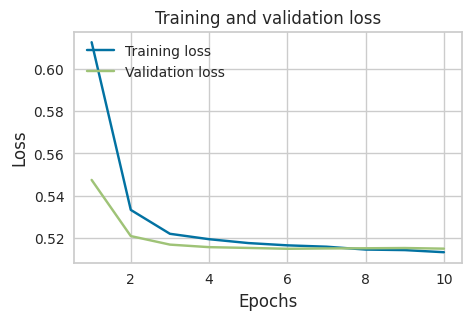

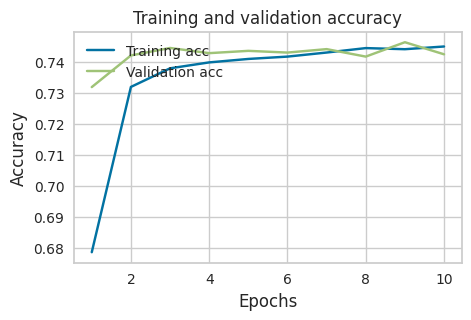

169/169 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.50      0.58      0.54      1554
           1       0.82      0.76      0.79      3846

    accuracy                           0.71      5400
   macro avg       0.66      0.67      0.66      5400
weighted avg       0.73      0.71      0.72      5400

Optimized threshold for best F1: 0.65


0.65

In [28]:
global_train_model(
    model=model,
    epochs=epochs,
    batch_size=64,
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss=loss,
    metrics=metrics)

In [14]:
model = Sequential()

model.add(layers.LSTM(
    first_layer_size,
    dropout=0.1,
    recurrent_dropout=0.5,
    input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(layers.Dense(1, activation='sigmoid'))

2023-02-26 17:03:51.116050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 17:03:51.116602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 17:03:51.116781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 17:03:51.116911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

2023-02-26 17:03:53.348744: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 6854400000 exceeds 10% of free system memory.
2023-02-26 17:04:33.518623: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 6854400000 exceeds 10% of free system memory.


Epoch 1/10


2023-02-26 17:04:38.568758: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


394/394 [==============================] - ETA: 0s - loss: 0.6105 - accuracy: 0.6945

2023-02-26 17:06:02.119036: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1468800000 exceeds 10% of free system memory.
2023-02-26 17:06:02.661151: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1468800000 exceeds 10% of free system memory.


394/394 [==============================] - 91s 223ms/step - loss: 0.6105 - accuracy: 0.6945 - val_loss: 0.5502 - val_accuracy: 0.7333
Epoch 2/10
394/394 [==============================] - 84s 212ms/step - loss: 0.5379 - accuracy: 0.7340 - val_loss: 0.5246 - val_accuracy: 0.7444
Epoch 3/10
394/394 [==============================] - 84s 212ms/step - loss: 0.5271 - accuracy: 0.7369 - val_loss: 0.5179 - val_accuracy: 0.7457
Epoch 4/10
394/394 [==============================] - 84s 213ms/step - loss: 0.5229 - accuracy: 0.7403 - val_loss: 0.5174 - val_accuracy: 0.7437
Epoch 5/10
394/394 [==============================] - 84s 213ms/step - loss: 0.5212 - accuracy: 0.7410 - val_loss: 0.5171 - val_accuracy: 0.7457
Epoch 6/10
394/394 [==============================] - 84s 213ms/step - loss: 0.5205 - accuracy: 0.7412 - val_loss: 0.5170 - val_accuracy: 0.7454
Epoch 7/10
394/394 [==============================] - 84s 214ms/step - loss: 0.5187 - accuracy: 0.7427 - val_loss: 0.5168 - val_accuracy: 0.7

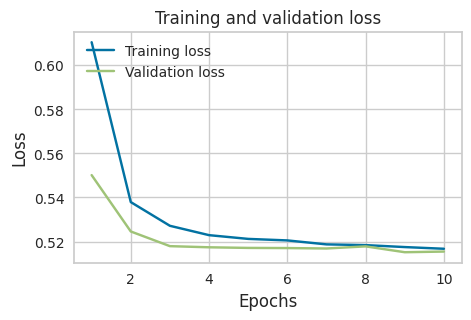

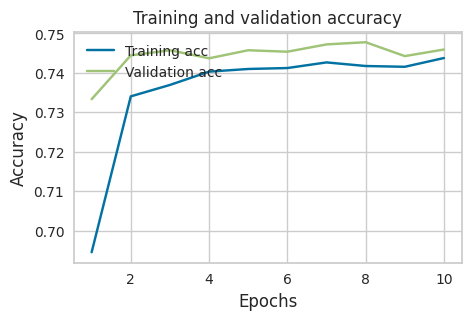

2023-02-26 17:18:47.762938: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1468800000 exceeds 10% of free system memory.


169/169 [==============================] - 6s 36ms/step
              precision    recall  f1-score   support

           0       0.51      0.54      0.53      1554
           1       0.81      0.79      0.80      3846

    accuracy                           0.72      5400
   macro avg       0.66      0.67      0.66      5400
weighted avg       0.72      0.72      0.72      5400

Optimized threshold for best F1: 0.63


0.63

In [15]:
global_train_model(
    model=model,
    epochs=epochs,
    batch_size=64,
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss=loss,
    metrics=metrics)

## Stacked Layers

Epoch 1/10
394/394 [==============================] - 183s 458ms/step - loss: 0.6547 - accuracy: 0.6887 - val_loss: 4.0858 - val_accuracy: 0.7026
Epoch 2/10
394/394 [==============================] - 175s 444ms/step - loss: 0.6162 - accuracy: 0.6977 - val_loss: 2.3220 - val_accuracy: 0.7030
Epoch 3/10
394/394 [==============================] - 175s 444ms/step - loss: 0.5872 - accuracy: 0.6987 - val_loss: 2.3733 - val_accuracy: 0.7050
Epoch 4/10
394/394 [==============================] - 176s 447ms/step - loss: 0.5870 - accuracy: 0.7051 - val_loss: 1.2841 - val_accuracy: 0.7194
Epoch 5/10
394/394 [==============================] - 176s 446ms/step - loss: 0.5733 - accuracy: 0.7246 - val_loss: 54.5558 - val_accuracy: 0.7191
Epoch 6/10
394/394 [==============================] - 176s 446ms/step - loss: 0.5865 - accuracy: 0.7340 - val_loss: 128.9821 - val_accuracy: 0.7341
Epoch 7/10
394/394 [==============================] - 176s 446ms/step - loss: 0.5794 - accuracy: 0.7360 - val_loss: 5.115

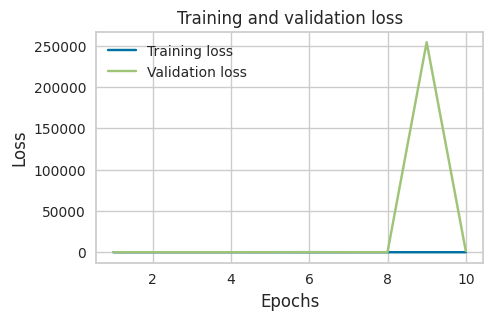

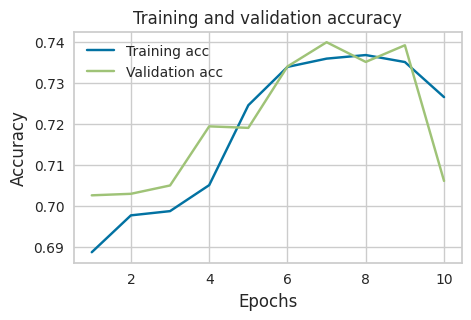

169/169 [==============================] - 11s 62ms/step
              precision    recall  f1-score   support

           0       0.48      0.50      0.49      1554
           1       0.79      0.78      0.79      3846

    accuracy                           0.70      5400
   macro avg       0.63      0.64      0.64      5400
weighted avg       0.70      0.70      0.70      5400

Optimized threshold for best F1: 0.56


0.56

In [16]:
# create the model
model = Sequential()
model.add(layers.LSTM(
    first_layer_size,
    dropout=0.1,
    recurrent_dropout=0.5,
    return_sequences=True,
    input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.LSTM(
    first_layer_size,
    activation='relu',
    dropout=0.1,
    recurrent_dropout=0.5))  
model.add(layers.Dense(1, activation='sigmoid'))

# train the model
global_train_model(
    model=model,
    epochs=epochs,
    batch_size=64,
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss=loss,
    metrics=metrics)